**Code references** 
- https://blog.keras.io/building-autoencoders-in-keras.html
- https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
- https://www.kaggle.com/zhoulingyan0228/generating-mnist-vae
- https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder

**References**
- http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf
- http://www.cs.toronto.edu/~urtasun/courses/CSC2541_Winter17/Deep_generative_models.pdf
- 

--- 

# MNIST 

In [40]:
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow.keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [41]:
def make_vae(latent_size, kl_coeff=1.0):
    encoder_input = Input((28,28,))
    x = Reshape((28,28,1))(encoder_input)
    x = ZeroPadding2D(padding=2)(x)
    for n in [32,64,128,128,128]:
        x = Conv2D(n, kernel_size=3, padding='same')(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=2)(x)
    x = Flatten()(x)
    z_mean = Dense(latent_size)(x)
    z_log_sigma = Dense(latent_size)(x)
    def sampling(args):
        z_mean, z_log_sigma = args
        epsilon = K.random_normal(shape=K.shape(z_mean),
                                  mean=0., stddev=1)
        return z_mean + K.exp(z_log_sigma) * epsilon

    z = Lambda(sampling, output_shape=(latent_size,))([z_mean, z_log_sigma])
    
    encoder = Model(encoder_input, z_mean)
    encoder.summary()

    decoder = Sequential()
    decoder.add(InputLayer((latent_size,)))
    decoder.add(Dense(128))
    decoder.add(Reshape((1,1,128)))
    for n in [128,128,64,32,1]:
        decoder.add(UpSampling2D(size=2))
        decoder.add(Conv2D(n, kernel_size=3, padding='same'))
        decoder.add(Activation('relu'))
        decoder.add(BatchNormalization())
    decoder.add(Conv2D(1, kernel_size=3, padding='same'))
    decoder.add(Activation('sigmoid'))
    decoder.add(Cropping2D(cropping=2))
    decoder.add(Reshape((28,28,)))
    decoder.summary()
    
    vae_output = decoder(z_mean)
    vae = Model(encoder_input, vae_output)
    vae.summary()
    
    def vae_loss(y_true, y_pred):
        recon_loss = K.sum(K.square(y_true-y_pred), axis=[1,2])
        kl_loss = - 0.5 * K.sum(1 + 2*z_log_sigma - K.square(z_mean) - K.square(K.exp(z_log_sigma)), axis=-1)
        return recon_loss + kl_coeff*kl_loss
    
    return encoder, decoder, vae, vae_loss

***Load data***

In [46]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [47]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
#x_train = np.reshape(x_train, [-1, original_dim])
#x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

**Network parameters**

In [48]:
encoder, decoder, vae, vae_loss = make_vae(2, kl_coeff=1.)
vae.compile(optimizer='adam', loss=vae_loss, metrics=[])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [50]:
epochs=100

vae.fit(x_train, 
        x_train, 
        epochs=epochs,
        callbacks=[EarlyStopping(monitor='loss', patience=2)],
        verbose=1)

Epoch 1/100
60000/60000 [==============================] - 395s 7ms/step - loss: 39.1338
Epoch 2/100
60000/60000 [==============================] - 412s 7ms/step - loss: 36.6041
Epoch 3/100
60000/60000 [==============================] - 404s 7ms/step - loss: 34.9170
Epoch 4/100
60000/60000 [==============================] - 408s 7ms/step - loss: 33.7249
Epoch 5/100
60000/60000 [==============================] - 419s 7ms/step - loss: 32.9758
Epoch 6/100
60000/60000 [==============================] - 400s 7ms/step - loss: 32.0582
Epoch 7/100
60000/60000 [==============================] - 401s 7ms/step - loss: 31.4304
Epoch 8/100
60000/60000 [==============================] - 389s 6ms/step - loss: 30.8116
Epoch 9/100
60000/60000 [==============================] - 400s 7ms/step - loss: 30.4927
Epoch 10/100
60000/60000 [==============================] - 413s 7ms/step - loss: 30.0741
Epoch 11/100
60000/60000 [==============================] - 417s 7ms/step - loss: 29.7486
Epoch 12/100
60000/

## VAE Reconstruction

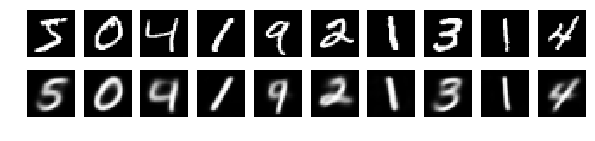

In [52]:
plt.figure(figsize=(10,2))
X_pred = vae.predict(x_train[:10])

for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')

for i in range(10):
    plt.subplot(2,10,10+i+1)
    plt.imshow(X_pred[i], cmap='gray')
    plt.axis('off')

## Visulizing Latent Space

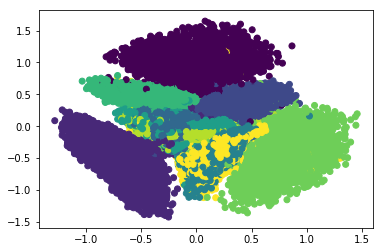

In [54]:
encoded = encoder.predict(x_train)
encoded_t = encoded.T
plt.scatter(encoded_t[0], encoded_t[1], c=y_train)

## Generating New Image by Sampling from Latent Space

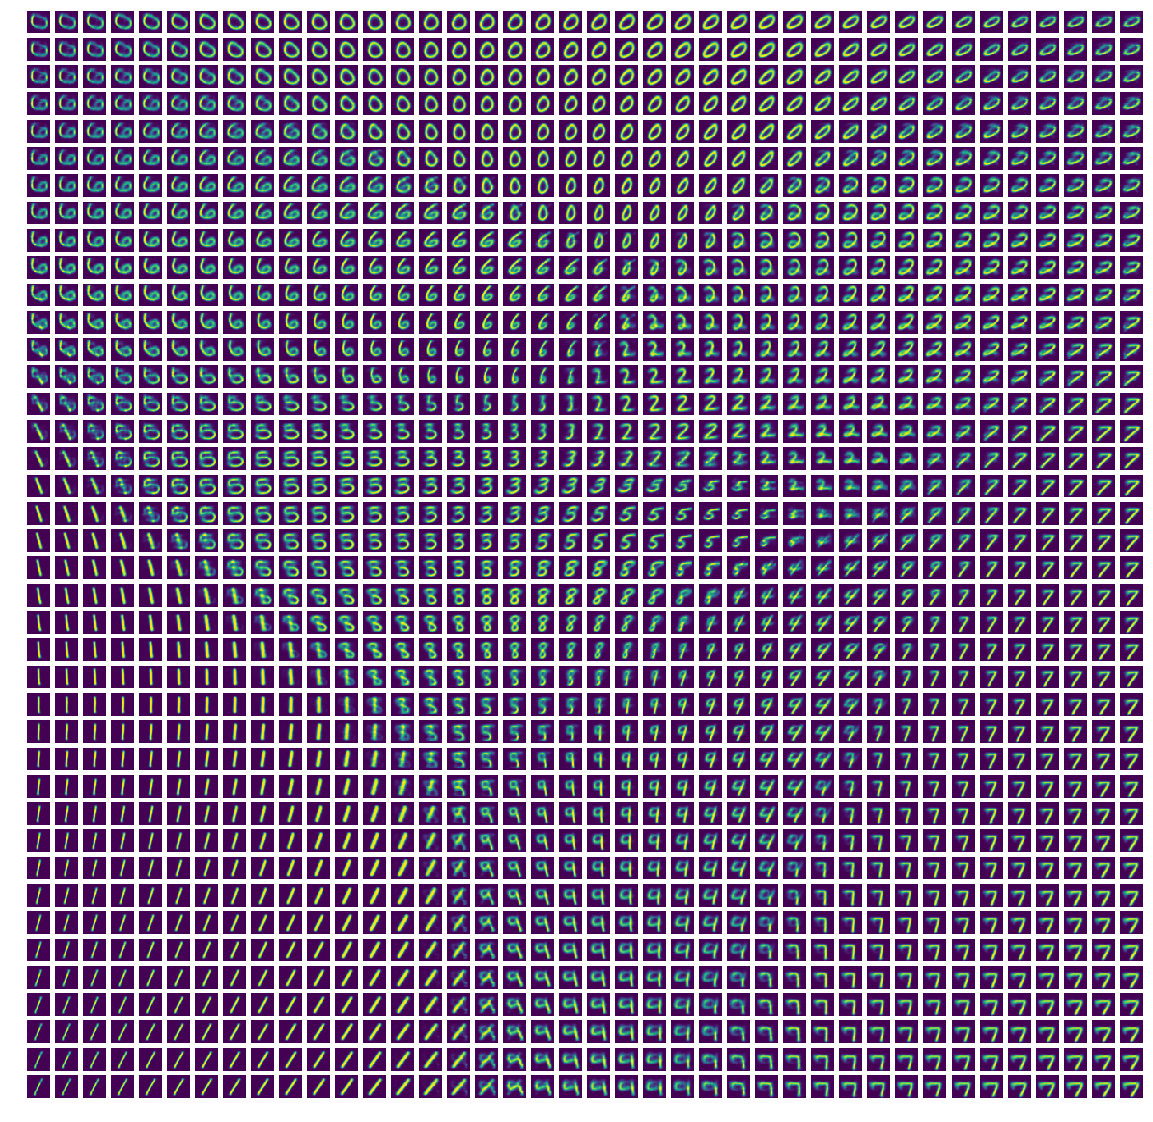

In [55]:
X,Y = np.meshgrid(np.arange(-1, 1, 0.05), np.arange(-1, 1, 0.05))
X = np.ravel(X)
Y = np.ravel(Y)
latents = np.stack([X, Y], axis=1)
generated = decoder.predict(latents)

plt.figure(figsize=(20,20))
for i in range(40):
    for j in range(40):
        plt.subplot(40,40,40*(39-i)+j+1)
        plt.imshow(generated[40*i+j])
        plt.axis('off')